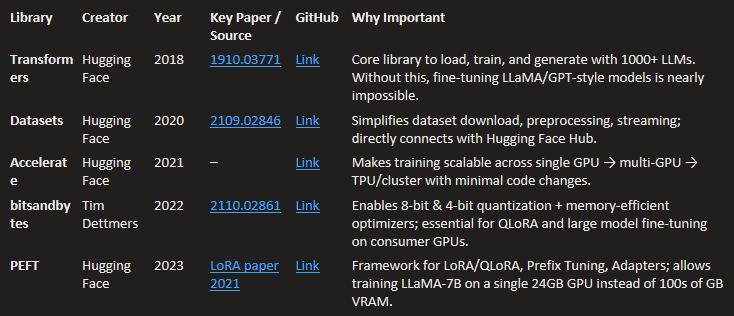

In [ ]:
!pip install -U peft bitsandbytes transformers accelerate

In [ ]:
!pip install -U trl

In [ ]:
!pip install PyMuPDF

## Prebuilt data from huggingface data hub

In [ ]:
from datasets import Dataset, load_dataset

In [ ]:
dataset = load_dataset("roneneldan/TinyStories", split="train")

In [ ]:
print(dataset)

In [ ]:
print(dataset[0])

In [ ]:
print(dataset[1])

In [ ]:
print(dataset[2])

## Our own custom data (non instrcution data) for domain specific finetuning

In [ ]:
import fitz

In [ ]:
def extract_text_from_pdf(pdf_path):
    text_blocks = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text = page.get_text("text").strip()
            if text:
                text_blocks.append(text)
    return text_blocks

In [ ]:
pdf_texts = extract_text_from_pdf("/content/Metformin.pdf")

In [ ]:
pdf_texts

| Model                        | Max Context Window (chunk length) during training | Approx words     | Comment                                                            |
| ---------------------------- | ------------------------------------------------- | ---------------- | ------------------------------------------------------------------ |
| **GPT-1 (2018)**             | 512 tokens                                        | ~350 words       | First transformer LM, small context                                |
| **GPT-2 (2019)**             | 1,024 tokens                                      | ~750 words       | Larger context for smoother coherence                              |
| **GPT-3 (2020)**             | 2,048 tokens                                      | ~1.5k words      | Trained on 300 B tokens with this window                           |
| **GPT-3.5 / ChatGPT (2022)** | 4,096 tokens                                      | ~3k words        | Used mixture of 2k–4k during pretraining + instruction fine-tuning |
| **GPT-4 (2023)**             | 8,192 – 32,768 – 1,28,000 tokens*                            | up to ~25k to 1L words | Multi-context variants (8k & 32k models)                           |


| Step                                     | What Happens                                                                             | Example                                     |
| ---------------------------------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------- |
| **1️⃣ Data Collection**                  | Crawl text from web (Wikipedia, CommonCrawl, Books, PubMed, Code, etc.)                  | Billions of documents                       |
| **2️⃣ Cleaning / Filtering**             | Remove HTML, junk, duplicates, low-quality content                                       | Similar to your `strip()` & len filter      |
| **3️⃣ Splitting / Chunking**             | Split into paragraphs / segments using regex rules, sentence boundaries, or token length | Like your `re.split(r'\n\s*\n')`            |
| **4️⃣ Tokenization**                     | Convert text chunks → token IDs using BPE                                                | “The cat” → `[1012, 52, 199]`               |
| **5️⃣ Training (Next-Token Prediction)** | Model learns to predict the next token in each chunk                                     | Input: “The cat sat on the” → Target: “mat” |


In [ ]:
import re
def split_paragraphs(pages):
    paragraphs = []
    for page_text in pages:
        # Split on double line breaks or long newlines
        chunks = re.split(r'\n\s*\n', page_text)
        for chunk in chunks:
            clean = chunk.strip()
            if len(clean) > 30:  # ignore too short lines
                paragraphs.append(clean)
    return paragraphs

In [ ]:
paragraphs = split_paragraphs(pdf_texts)

In [ ]:
data = [{"text": p} for p in paragraphs]

In [ ]:
print(data)

[{'text': 'Metformin is one of the most widely prescribed oral antihyperglycemic agents.\u200b\n Its primary mechanism of action involves the activation of AMP-activated protein kinase \n(AMPK), a central metabolic regulator that promotes glucose uptake and fatty acid oxidation \nwhile inhibiting hepatic gluconeogenesis.\u200b\n Beyond its glycemic control, Metformin has been shown to improve cardiovascular outcomes \nand display anti-inflammatory properties.\u200b\n Recent studies also suggest potential anticancer effects through inhibition of the mTOR \nsignaling pathway and suppression of tumor angiogenesis.'},

{'text': 'Clinical trials have demonstrated that combining Atorvastatin with Ezetimibe results in \nsignificant reductions in low-density lipoprotein cholesterol (LDL-C) levels compared to \nmonotherapy.\u200b\n Ezetimibe acts by inhibiting the Niemann–Pick C1-like 1 (NPC1L1) transporter in the intestinal \nwall, reducing cholesterol absorption, while Atorvastatin inhibits hepatic HMG-CoA reductase, \nsuppressing endogenous cholesterol synthesis.\u200b\n The dual mechanism provides an additive lipid-lowering effect, particularly beneficial for \npatients with familial hypercholesterolemia who are unresponsive to statins alone.'},

{'text': 'The success of mRNA vaccines against SARS-CoV-2 has opened new pathways for rapid \nvaccine development.\u200b\n mRNA platforms enable flexible design and quick adaptation to emerging viral variants such as \nBQ.1 and XBB.1.5.\u200b\n Phase-II clinical trials have shown strong immunogenicity with elevated neutralizing antibody \ntiters and robust CD8⁺ T-cell responses.\u200b\n Ongoing research is exploring thermostable formulations and self-amplifying mRNA constructs \nto enhance global distribution and cost-efficiency.'},

{'text': 'Artificial intelligence (AI) is transforming pharmaceutical research by accelerating target \nidentification, molecular docking, and compound screening.\u200b\n Deep learning models trained on large-scale biological datasets can predict protein–ligand \nbinding affinities and optimize lead compounds.\u200b\n Integrating AI-driven insights with laboratory automation is reducing discovery timelines from \nyears to months.\u200b\n However, challenges remain regarding interpretability, bias mitigation, and regulatory validation \nfor AI-generated molecules.'}]

In [ ]:
dataset = Dataset.from_list(data)

In [ ]:
dataset

## Lets Select the Model

The checkpoint is from a TinyLLaMA model trained for ~1.4M steps over 3 trillion tokens,
captured midway before final convergence.

In [ ]:
# model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-3.1-8B"
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

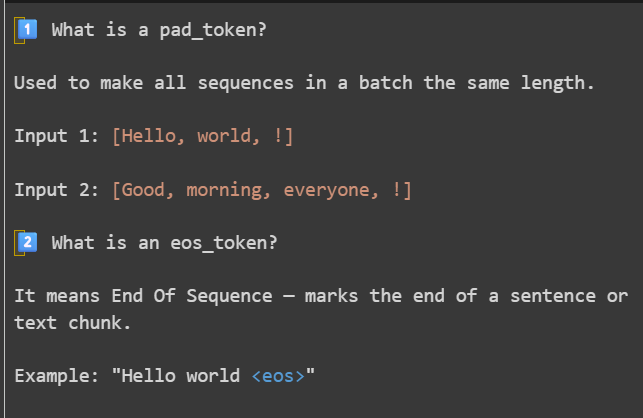

In [ ]:
def tokenize_fn(examples):
    tokens = tokenizer(examples["text"],truncation=True,padding="max_length",max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

1️⃣ Input

examples["text"]
→ This comes from your dataset, like:

{"text": "Metformin improves insulin sensitivity in the liver."}


2️⃣ Tokenization
tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

| Argument               | Meaning                                                                              |
| ---------------------- | ------------------------------------------------------------------------------------ |
| `truncation=True`      | If the text is longer than 512 tokens, cut it off (keep only first 512).             |
| `padding="max_length"` | If the text is shorter than 512 tokens, pad it with `<pad>` tokens up to 512 length. |
| `max_length=512`       | Fixed sequence length per training example (standard size).                          |

{
  'input_ids': [1, 4382, 272, 98, ... , 2, 2, 2],
  'attention_mask': [1, 1, 1, ... , 0, 0, 0]
}

3️⃣ Labels

tokens["labels"] = tokens["input_ids"].copy()

This is the key step for causal (unsupervised) language modeling.

It means: “The model should try to predict the next token of this same sequence.”

Example:
| Input Tokens                 | Target Labels (Shifted Internally) |
| ---------------------------- | ---------------------------------- |
| `Metformin improves insulin` | `improves insulin sensitivity`     |

So model learns:

“Given previous words, predict the next word.”

That’s how GPT-style unsupervised training works — no Q/A, no instruction, just next-token prediction.

4️⃣ Output Returned

The final dictionary returned looks like this:

{

  "input_ids": [...],

  "attention_mask": [...],
  
  "labels": [...]

}

In [ ]:
tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])

In [ ]:
tokenized

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)

| Parameter                       | Purpose                | Typical Range | Effect                      |
| ------------------------------- | ---------------------- | ------------- | --------------------------- |
| **output_dir**                  | Save model/checkpoints | Folder path   | Where your model ends up    |
| **overwrite_output_dir**        | Allow overwrite        | True / False  | Avoids folder conflicts     |
| **num_train_epochs**            | Training cycles        | 1–5           | More = longer training      |
| **per_device_train_batch_size** | Batch per GPU          | 1–8 (Colab)   | Affects speed & memory      |
| **save_steps**                  | Save frequency         | 100–1000      | More = frequent checkpoints |
| **save_total_limit**            | Keep last N            | 1–3           | Saves disk                  |
| **logging_steps**               | Log every X steps      | 20–100        | For progress monitoring     |
| **learning_rate**               | Weight update rate     | 1e-5–5e-5     | Controls stability          |
| **fp16**                        | Mixed precision        | True          | Faster + less memory        |
| **report_to**                   | Logging destination    | "none"        | Keeps it simple             |


In [ ]:
training_args = TrainingArguments(
    output_dir="./llama-pharma-domain",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

In [ ]:
from transformers import TrainingArguments
help(TrainingArguments)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized
)

In [ ]:
trainer.train()

### Here we are not specfiying anything means this is full fine-tuning
### Now we have two methods for Partial Finetuning
- Feerze some layer and finetune unfreeze layer(old CNN and Bert sytel method)
- LORA(Append some external weight to the already trained pretrain weight)

- First Lets's see the method where we are going to freeze the layer

In [ ]:
# # -------------------------------------------------------------
# # 1️⃣ Install dependencies
# # -------------------------------------------------------------
# !pip install -q transformers datasets accelerate bitsandbytes

# # -------------------------------------------------------------
# # 2️⃣ Imports
# # -------------------------------------------------------------
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
# from datasets import load_dataset
# import os, re

# # -------------------------------------------------------------
# # 3️⃣ Load base model and tokenizer
# # -------------------------------------------------------------
# model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

# # -------------------------------------------------------------
# # 4️⃣ Freeze everything
# # -------------------------------------------------------------
# for param in model.parameters():
#     param.requires_grad = False

# # -------------------------------------------------------------
# # 5️⃣ Unfreeze last 4 transformer blocks + lm_head
# # -------------------------------------------------------------
# for name, param in model.named_parameters():
#     if any(f"layers.{i}." in name for i in range(20, 24)):  # last 4 layers
#         param.requires_grad = True
#     if "lm_head" in name:
#         param.requires_grad = True

# # Verify how many parameters are trainable
# trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total = sum(p.numel() for p in model.parameters())
# print(f"✅ Trainable: {trainable/total*100:.2f}% of total parameters")

# # -------------------------------------------------------------
# # 6️⃣ Load your dataset
# # -------------------------------------------------------------
# dataset = load_dataset("json", data_files={"train": "pharma_non_instruction.jsonl"})

# def tokenize_fn(examples):
#     tokens = tokenizer(
#         examples["text"],
#         truncation=True,
#         padding="max_length",
#         max_length=512
#     )
#     tokens["labels"] = tokens["input_ids"].copy()
#     return tokens

# tokenized = dataset["train"].map(tokenize_fn, batched=True, remove_columns=["text"])

# # -------------------------------------------------------------
# # 7️⃣ Data collator for causal LM
# # -------------------------------------------------------------
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# # -------------------------------------------------------------
# # 8️⃣ Training arguments
# # -------------------------------------------------------------
# os.environ["WANDB_DISABLED"] = "true"  # disable wandb
# training_args = TrainingArguments(
#     output_dir="./tinyllama-pharma-last4",
#     overwrite_output_dir=True,
#     num_train_epochs=2,
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     learning_rate=1e-4,        # slightly higher since fewer params
#     fp16=True,
#     logging_steps=20,
#     save_steps=200,
#     save_total_limit=2,
#     report_to="none"
# )

# # -------------------------------------------------------------
# # 9️⃣ Trainer setup
# # -------------------------------------------------------------
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized,
#     data_collator=data_collator
# )

# # -------------------------------------------------------------
# # 🔟 Start training
# # -------------------------------------------------------------
# trainer.train()

# # -------------------------------------------------------------
# # 11️⃣ Save final model
# # -------------------------------------------------------------
# trainer.save_model("./tinyllama-pharma-last4-final")
# print("\n✅ Training completed and model saved!")


### Now lets see the LORA based method

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install -U peft bitsandbytes transformers accelerate

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset

In [ ]:
model = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model)

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenize_fn(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [ ]:
tokenized = dataset.map(tokenize_fn, batched=True)

In [ ]:
tokenized

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model,
    load_in_8bit=True,
    device_map="auto"
)

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none"
)

In [ ]:
# save adapter
non_inst_model_lora = get_peft_model(model, lora_config)

In [ ]:
args = TrainingArguments(
    output_dir="./tinyllama-lora",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=non_inst_model_lora,
    args=args,
    train_dataset=tokenized
)

In [ ]:
trainer.train()

In [ ]:
model_path = "/content/tinyllama-lora/checkpoint-5"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [ ]:
prompt = "Clinical trials demonstrated that combining Atorvastatin with Ezetimibe"

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [ ]:
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

In [ ]:
print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Non-Instruction Finetuning Dataset

In [ ]:
dataset = load_dataset("HuggingFaceFW/fineweb")
pubmed = load_dataset("ncbi/pubmed")
dataset = load_dataset("datajuicer/the-pile-pubmed-abstracts-refined-by-data-juicer")
dataset = load_dataset("open-llm-leaderboard/open_llm_corpus")
owt = load_dataset("Skylion007/openwebtext")
ds = load_dataset("armanc/scientific_papers")

### Instruction Finetuning Dataset

In [ ]:
https://huggingface.co/datasets/Amod/mental_health_counseling_conversations
https://huggingface.co/datasets/yahma/alpaca-cleaned
https://huggingface.co/datasets/Open-Orca/OpenOrca
https://huggingface.co/datasets/tatsu-lab/alpaca
https://huggingface.co/datasets/OpenAssistant/oasst1

## Prefrence Alignemnt tuing dataset

In [ ]:
https://huggingface.co/datasets/Anthropic/hh-rlhf
https://huggingface.co/datasets/argilla/ultrafeedback-binarized-preferences-cleaned
https://huggingface.co/datasets/xinlai/Math-Step-DPO-10K